In [73]:
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('train.csv',engine='c',memory_map=True)

In [3]:
pickupDatetime  = pd.to_datetime(df.pickup_datetime)
dropoffDatetime = pd.to_datetime(df.dropoff_datetime)

dfDrop = df.drop(['id','pickup_datetime','dropoff_datetime'],axis=1)

# On reccréé des colonnes de pickup en séparant les informations de la date
dfDrop['pickupHour'] = pickupDatetime.dt.hour
dfDrop['pickupDayOfWeek'] = pickupDatetime.dt.dayofweek
dfDrop['pickupWeekOfYear'] = pickupDatetime.dt.weekofyear
dfDrop['pickupDayOfYear'] = pickupDatetime.dt.dayofyear

# Pareil pour le dropoff
dfDrop['dropoffHour'] = dropoffDatetime.dt.hour
dfDrop['dropoffDayOfWeek'] = dropoffDatetime.dt.dayofweek
dfDrop['dropoffWeekOfYear'] = dropoffDatetime.dt.weekofyear
dfDrop['dropoffDayOfYear'] = dropoffDatetime.dt.dayofyear

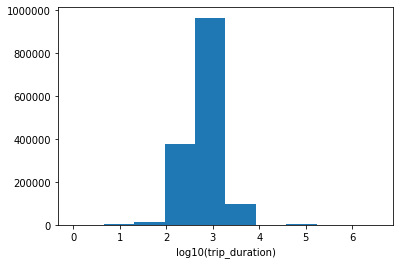

In [4]:
plt.hist(np.log10(df.trip_duration.values))
plt.xlabel('log10(trip_duration)')
plt.show()

In [5]:
# Avec ce graphique, on voit que la majoritée des valeurs se situent entre 10^2 et 10^(3,5) ~= 3200
# On peut donc supprimer les autres valeurs
dfGoodDurations = dfDrop[(dfDrop.trip_duration >= 100) & (dfDrop.trip_duration < 3200)]
print(dfDrop.shape)
print(dfGoodDurations.shape)

(1458644, 16)
(1420735, 16)


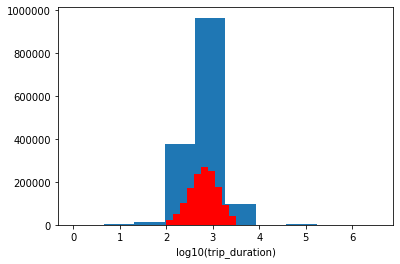

In [6]:
# Beaucoup de valeur ont enlevé
plt.hist(np.log10(df.trip_duration.values))
plt.hist(np.log10(dfGoodDurations.trip_duration.values),color='red')
plt.xlabel('log10(trip_duration)')
plt.show()

In [7]:
# On veut afficher la matrice de corrélation pour voir quelle variables dépendent le plus linéairement des autres. Pour cela on a besoin de transformer les valeurs de la colonne store_and_fwd_flag en chiffre. Pour cela on va utiliser un OHEncoder. Pour l'instant je vais juste les enlever
dfUsable = dfGoodDurations.drop(['store_and_fwd_flag'], axis=1)

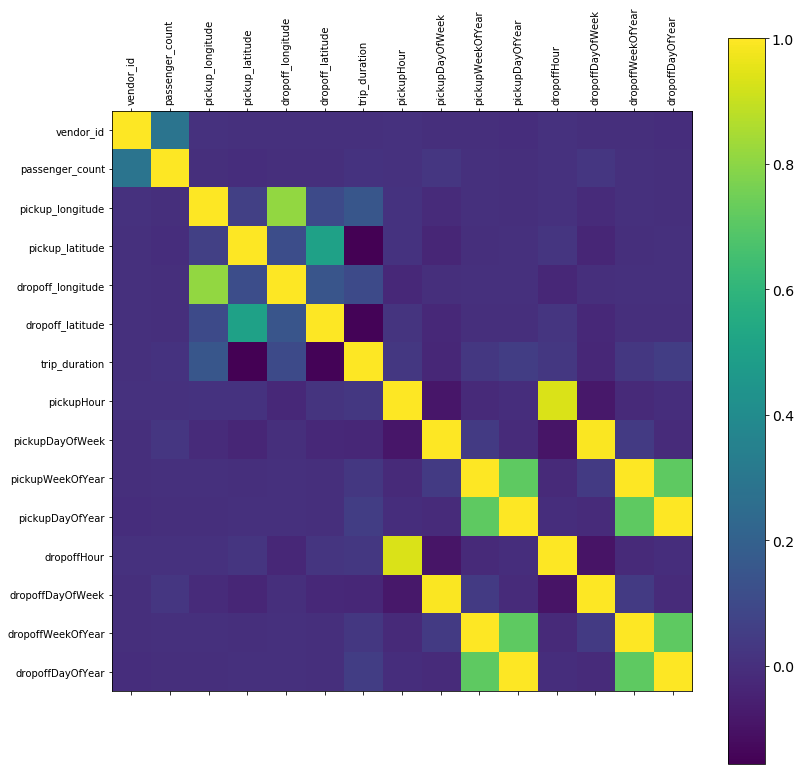

In [8]:
# On affiche la matrice de corélation pour voir quelles valeurs sont +/- corrélée entre elles
f = plt.figure(figsize=(13,13))
plt.matshow(dfUsable.corr(), fignum=f.number)
plt.xticks(range(dfUsable.shape[1]),labels=dfUsable.columns,rotation=90)
plt.yticks(range(dfUsable.shape[1]),dfUsable.columns)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

In [9]:
dfUsable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1420735 entries, 0 to 1458643
Data columns (total 15 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   vendor_id          1420735 non-null  int64  
 1   passenger_count    1420735 non-null  int64  
 2   pickup_longitude   1420735 non-null  float64
 3   pickup_latitude    1420735 non-null  float64
 4   dropoff_longitude  1420735 non-null  float64
 5   dropoff_latitude   1420735 non-null  float64
 6   trip_duration      1420735 non-null  int64  
 7   pickupHour         1420735 non-null  int64  
 8   pickupDayOfWeek    1420735 non-null  int64  
 9   pickupWeekOfYear   1420735 non-null  int64  
 10  pickupDayOfYear    1420735 non-null  int64  
 11  dropoffHour        1420735 non-null  int64  
 12  dropoffDayOfWeek   1420735 non-null  int64  
 13  dropoffWeekOfYear  1420735 non-null  int64  
 14  dropoffDayOfYear   1420735 non-null  int64  
dtypes: float64(4), int64(11)
memory 

In [10]:
# On voit que trip_duration n'est pas corrélé linéairement avec beaucoup de variables. Il est donc probable que les algorithmes de regression linéaires ne donnent pas de bon résultats. On va essayer de trouver quelles variables sont intéressantes pour l'apprentissage.
print(dfUsable.passenger_count.value_counts())

1    1006618
2     204748
5      76156
3      58474
6      47113
4      27611
0         13
9          1
8          1
Name: passenger_count, dtype: int64


In [11]:
# On voit qu'il y a quelques valeurs pour 0 9 et 8 passagers. Comme on veut prédire des trajets, le but est qu'il y ait des passagers dans les taxi, on peut donc supprimer les lignes avec 0 passager, et 9 et 8, 1 seule entrée est innutile pour l'apprentissage
dfWithoutBadPCount = dfUsable[(dfUsable.passenger_count != 0) & (dfUsable.passenger_count != 9) & (dfUsable.passenger_count != 8)]

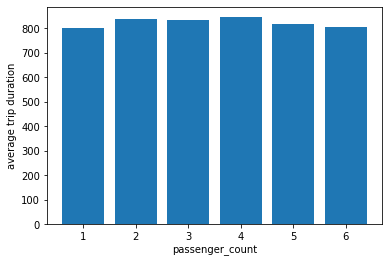

In [12]:
groupByPassengerCount = dfWithoutBadPCount.groupby('passenger_count')[['trip_duration']].mean()
groupByPassengerCount.reset_index(inplace=True)
plt.bar(groupByPassengerCount.passenger_count.values,groupByPassengerCount.trip_duration.values)
plt.xlabel('passenger_count')
plt.ylabel('average trip duration')
plt.show()

In [13]:
# Les valeurs sont assez proches (entre 800 et 840), on peut donc supprimer le champs nombre de passagers qui n'a pas l'ai très intéressant
dfWithoutPCount = dfWithoutBadPCount.loc[:, dfWithoutBadPCount.columns != 'passenger_count']

/home/adrien/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


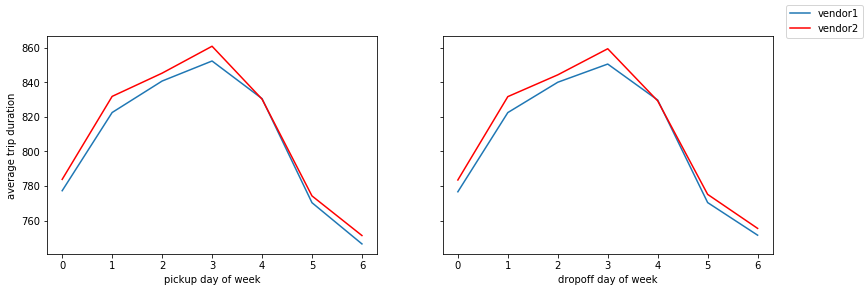

In [14]:
# On va regarder si les informations de dates sont importantes
tripDurationByVendorID_pickupDayOfWeek = dfWithoutPCount.groupby(['vendor_id', 'pickupDayOfWeek'])[['trip_duration']].mean()
tripDurationByVendorID_pickupDayOfWeek.reset_index(inplace=True)
pickupVendor1 = tripDurationByVendorID_pickupDayOfWeek[tripDurationByVendorID_pickupDayOfWeek.vendor_id == 1]
pickupVendor2 = tripDurationByVendorID_pickupDayOfWeek[tripDurationByVendorID_pickupDayOfWeek.vendor_id == 2]

tripDurationByVendorID_dropoffDayOfWeek = dfWithoutPCount.groupby(['vendor_id', 'dropoffDayOfWeek'])[['trip_duration']].mean()
tripDurationByVendorID_dropoffDayOfWeek.reset_index(inplace=True)
dropoffVendor1 = tripDurationByVendorID_dropoffDayOfWeek[tripDurationByVendorID_dropoffDayOfWeek.vendor_id == 1]
dropoffVendor2 = tripDurationByVendorID_dropoffDayOfWeek[tripDurationByVendorID_dropoffDayOfWeek.vendor_id == 2]

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True,figsize=(13,4))
ax1.set(ylabel='average trip duration', xlabel='pickup day of week')
ax2.set(xlabel='dropoff day of week')

ax1.plot(pickupVendor1.pickupDayOfWeek,pickupVendor1.trip_duration,label='vendor1')
ax1.plot(pickupVendor2.pickupDayOfWeek,pickupVendor2.trip_duration,color='red',label='vendor2')

ax2.plot(dropoffVendor1.dropoffDayOfWeek,dropoffVendor1.trip_duration)
ax2.plot(dropoffVendor2.dropoffDayOfWeek,dropoffVendor2.trip_duration,color='red')

fig.legend()
fig.show()

/home/adrien/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


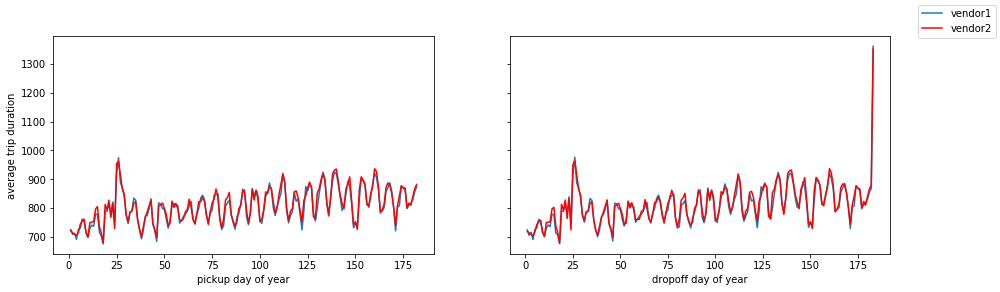

In [15]:
tripDurationByVendorID_pickupDayOfYear = dfWithoutPCount.groupby(['vendor_id', 'pickupDayOfYear'])[['trip_duration']].mean()
tripDurationByVendorID_pickupDayOfYear.reset_index(inplace=True)
pickupVendor1 = tripDurationByVendorID_pickupDayOfYear[tripDurationByVendorID_pickupDayOfYear.vendor_id == 1]
pickupVendor2 = tripDurationByVendorID_pickupDayOfYear[tripDurationByVendorID_pickupDayOfYear.vendor_id == 2]

tripDurationByVendorID_dropoffDayOfYear = dfWithoutPCount.groupby(['vendor_id', 'dropoffDayOfYear'])[['trip_duration']].mean()
tripDurationByVendorID_dropoffDayOfYear.reset_index(inplace=True)
dropoffVendor1 = tripDurationByVendorID_dropoffDayOfYear[tripDurationByVendorID_dropoffDayOfYear.vendor_id == 1]
dropoffVendor2 = tripDurationByVendorID_dropoffDayOfYear[tripDurationByVendorID_dropoffDayOfYear.vendor_id == 2]

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True,figsize=(15,4))
ax1.set(ylabel='average trip duration', xlabel='pickup day of year')
ax2.set(xlabel='dropoff day of year')

ax1.plot(pickupVendor1.pickupDayOfYear,pickupVendor1.trip_duration,label='vendor1')
ax1.plot(pickupVendor2.pickupDayOfYear,pickupVendor2.trip_duration,color='red',label='vendor2')

ax2.plot(dropoffVendor1.dropoffDayOfYear,dropoffVendor1.trip_duration)
ax2.plot(dropoffVendor2.dropoffDayOfYear,dropoffVendor2.trip_duration,color='red')

fig.legend()
fig.show()

/home/adrien/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


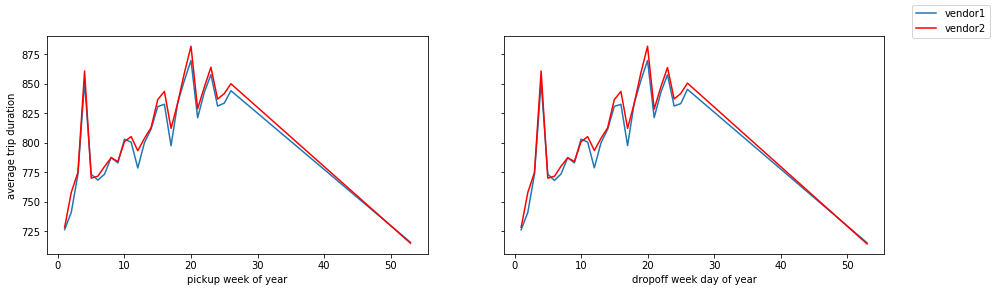

In [16]:
tripDurationByVendorID_pickupWeekOfYear = dfWithoutPCount.groupby(['vendor_id', 'pickupWeekOfYear'])[['trip_duration']].mean()
tripDurationByVendorID_pickupWeekOfYear.reset_index(inplace=True)
pickupVendor1 = tripDurationByVendorID_pickupWeekOfYear[tripDurationByVendorID_pickupWeekOfYear.vendor_id == 1]
pickupVendor2 = tripDurationByVendorID_pickupWeekOfYear[tripDurationByVendorID_pickupWeekOfYear.vendor_id == 2]

tripDurationByVendorID_dropoffWeekOfYear = dfWithoutPCount.groupby(['vendor_id', 'dropoffWeekOfYear'])[['trip_duration']].mean()
tripDurationByVendorID_dropoffWeekOfYear.reset_index(inplace=True)
dropoffVendor1 = tripDurationByVendorID_dropoffWeekOfYear[tripDurationByVendorID_dropoffWeekOfYear.vendor_id == 1]
dropoffVendor2 = tripDurationByVendorID_dropoffWeekOfYear[tripDurationByVendorID_dropoffWeekOfYear.vendor_id == 2]

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True,figsize=(15,4))
ax1.set(ylabel='average trip duration', xlabel='pickup week of year')
ax2.set(xlabel='dropoff week day of year')

ax1.plot(pickupVendor1.pickupWeekOfYear,pickupVendor1.trip_duration,label='vendor1')
ax1.plot(pickupVendor2.pickupWeekOfYear,pickupVendor2.trip_duration,color='red',label='vendor2')

ax2.plot(dropoffVendor1.dropoffWeekOfYear,dropoffVendor1.trip_duration)
ax2.plot(dropoffVendor2.dropoffWeekOfYear,dropoffVendor2.trip_duration,color='red')

fig.legend()
fig.show()

/home/adrien/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


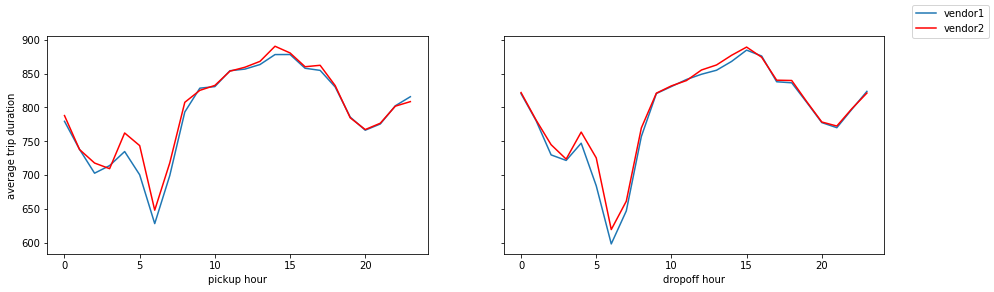

In [17]:
tripDurationByVendorID_pickupHour = dfWithoutPCount.groupby(['vendor_id', 'pickupHour'])[['trip_duration']].mean()
tripDurationByVendorID_pickupHour.reset_index(inplace=True)
pickupVendor1 = tripDurationByVendorID_pickupHour[tripDurationByVendorID_pickupHour.vendor_id == 1]
pickupVendor2 = tripDurationByVendorID_pickupHour[tripDurationByVendorID_pickupHour.vendor_id == 2]

tripDurationByVendorID_dropoffHour = dfWithoutPCount.groupby(['vendor_id', 'dropoffHour'])[['trip_duration']].mean()
tripDurationByVendorID_dropoffHour.reset_index(inplace=True)
dropoffVendor1 = tripDurationByVendorID_dropoffHour[tripDurationByVendorID_dropoffHour.vendor_id == 1]
dropoffVendor2 = tripDurationByVendorID_dropoffHour[tripDurationByVendorID_dropoffHour.vendor_id == 2]

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True,figsize=(15,4))
ax1.set(ylabel='average trip duration', xlabel='pickup hour')
ax2.set(xlabel='dropoff hour')

ax1.plot(pickupVendor1.pickupHour,pickupVendor1.trip_duration,label='vendor1')
ax1.plot(pickupVendor2.pickupHour,pickupVendor2.trip_duration,color='red',label='vendor2')

ax2.plot(dropoffVendor1.dropoffHour,dropoffVendor1.trip_duration)
ax2.plot(dropoffVendor2.dropoffHour,dropoffVendor2.trip_duration,color='red')

fig.legend()
fig.show()

In [47]:
# On voit avec ces graphiques que globalement le vendeur 2 met un peu plus de temps que le vendeur 1 mais surtout que la date de pickup ou de dropoff donne des courbes presques parfaitement similaire, on peut donc n'en garder qu'une des deux. On choisit de garder pickup
dropCols = ['vendor_id','dropoffDayOfWeek','dropoffWeekOfYear','dropoffDayOfYear','dropoffHour']
dfWithoutUseless = dfWithoutPCount.drop(dropCols,axis=1)

/home/adrien/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


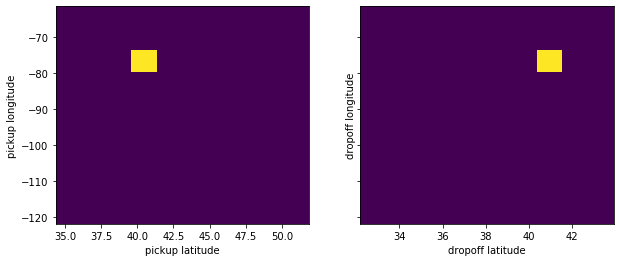

In [48]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4),sharey=True)

ax1.set(xlabel='pickup latitude',ylabel='pickup longitude')
ax2.set(xlabel='dropoff latitude',ylabel='dropoff longitude')

ax1.hist2d(dfWithoutUseless.pickup_latitude,dfWithoutUseless.pickup_longitude,label='pickup coord')
ax2.hist2d(dfWithoutUseless.dropoff_latitude,dfWithoutUseless.dropoff_longitude,label='dropoff coord')
fig.show()

In [63]:
# On peut supprimer les lattitudes entre 40 et 42 et les longitudes entre -70 et -80
dfGoodLocation = dfWithoutUseless[(dfWithoutUseless.pickup_longitude >= -74.05) & (dfWithoutUseless.pickup_longitude <= -73.7) & (dfWithoutUseless.pickup_latitude >= 40.60) & (dfWithoutUseless.pickup_latitude <= 40.9) & (dfWithoutUseless.dropoff_longitude >= -74.05) & (dfWithoutUseless.dropoff_longitude <= -73.7) & (dfWithoutUseless.dropoff_latitude >= 40.60) & (df.dropoff_latitude <= 40.9)]
print(dfWithoutUseless.shape)
print(dfGood.shape)

(1420720, 9)
(1415740, 9)
/home/adrien/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


/home/adrien/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


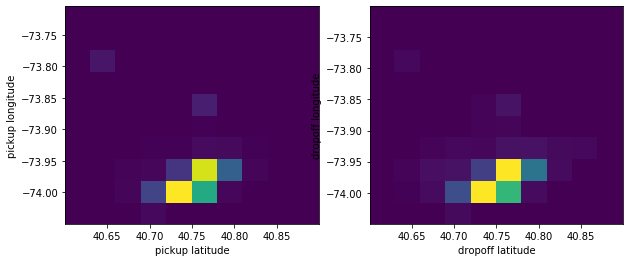

In [72]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.set(xlabel='pickup latitude',ylabel='pickup longitude')
ax2.set(xlabel='dropoff latitude',ylabel='dropoff longitude')

ax1.hist2d(dfGoodLocation.pickup_latitude,dfGoodLocation.pickup_longitude,label='pickup coord')
ax2.hist2d(dfGoodLocation.dropoff_latitude,dfGoodLocation.dropoff_longitude,label='dropoff coord')

fig.show()

In [ ]:
# On a supprimer les locations trop éloignée, on va maintenant faire un cluqtering des pickups
kmeanPickup = KMeans(n_clusters=15,random_state=2,n_init=1).fit(dfGoodLocation[['pickup_longitude','pickup_latitude']])


In [65]:
# Maintenant que l'on a des données exploitable, on va pouvoir commencer l'entraînement (et croiser les doigts pour que ça marche mieux)
X = dfGood.loc[:,dfGood.columns != 'trip_duration']
Y = dfGood.trip_duration
XTrain, XTest, YTrain, Ytest = train_test_split(X,Y,train_size=0.8,random_state=19061996)

In [66]:
def train (n, d,jobs=None):
    startingMsg = "Starting n={} d={} ".format(n,d)
    print(startingMsg,end='')
    
    model = RandomForestRegressor(random_state=19061996,n_estimators=n, max_depth=d,n_jobs=jobs)

    start = time.time()
    model.fit(XTrain,YTrain)
    end = time.time()

    preds = model.predict(XTest)

    errorInSeconds = mean_absolute_error(Ytest,preds)
    error = np.sqrt(mean_squared_log_error(Ytest,preds))

    endMsg = " t={}s e={}(={}s)\n".format(format(end-start),error,errorInSeconds)
    print(endMsg,end='')

In [67]:
N = [30,40,50,60,70,80]
D = [10,20,30,40]

# +---------> D
# |
#\|/
# N
mask = [[1,1,1,1],[1,1,1,1],[1,1,1,1],[1,1,1,1],[1,1,1,1],[1,1,1,1]]

#Je vérifie que je n'est pas fait de la merde
assert(len(mask) == len(N))
for i in range(len(N)):
    assert(len(mask[i]) == len(D))

In [68]:
for i in range(len(N)):
    for j in range (len(D)):
        if mask[i][j] == 1:
            train(N[i],D[j],4)
    print('')
    

Starting n=30 d=10 t=55.70224380493164s e=0.557696816923142(=286.5090430854936s)
Starting n=30 d=20 t=87.54702258110046s e=0.39033054870844547(=192.94254191950932s)
Starting n=30 d=30

KeyboardInterrupt: 